In [1]:
import pandas as pd
import random
from datasets import load_dataset
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

In [2]:
seed = 42
random.seed(seed)  

In [3]:
dataset = load_dataset("sled-umich/Action-Effect")
dataset_df = dataset['ActionEffect'].to_pandas()
del dataset

Found cached dataset action-effect (/home/junjayz/.cache/huggingface/datasets/sled-umich___action-effect/default/1.0.0/c2d728abba7d24ff02f369c6d8bf19d67cb3c4b1159604a10826b810752a8083)


  0%|          | 0/1 [00:00<?, ?it/s]

## Get useful features

In [4]:
dataset_df['action'] = dataset_df['verb noun'].apply(lambda x: x.split(' ')[0])
dataset_df['object'] = dataset_df['verb noun'].apply(lambda x: x.split(' ')[1])
dataset_df.drop(columns=['verb noun','positive_image_list', 'negative_image_list'], inplace=True)

In [5]:
dataset_df = dataset_df.loc[:, ['action', 'object', 'effect_sentence_list']]

In [6]:
dataset_df['effect_sentence_list'] = dataset_df['effect_sentence_list'].apply(lambda x: [i.replace('object', 'item') for i in x])

In [7]:
def replace_object(row):
    wnl = WordNetLemmatizer()
    try:
        object_word = wnl.lemmatize(row['object'], 'n')
    except:
        object_word = row['object'] if row['object'][-1] != 's' else row['object'][:-1]
    row['effect_sentence_list'] = [i.replace(object_word,'object') for i in row['effect_sentence_list']]
    return row

dataset_df = dataset_df.apply(replace_object, axis=1)

In [8]:
dataset_df

,action,object,effect_sentence_list
0,arrange,chairs,"[objects are moved around in order, the object..."
1,arrange,flowers,"[the objects are in a pretty design, objects a..."
2,bake,potato,"[i put a object in the oven to bake it, the ob..."
3,beat,eggs,"[the objects are stirred, the objects are scra..."
4,bend,knee,"[my object needs surgery, a object is folding ..."
...,...,...,...
135,trim,tree,"[the object looks festive for the holiday, the..."
136,twist,hair,"[the object is turned around on itself, the ob..."
137,twist,rope,"[the object is being contorted, the object is ..."
138,wrap,book,[the object is concealed behind wrapping paper...


## Split data into train, test, and validation sets

<AxesSubplot: xlabel='Samples Per object', ylabel='Count'>

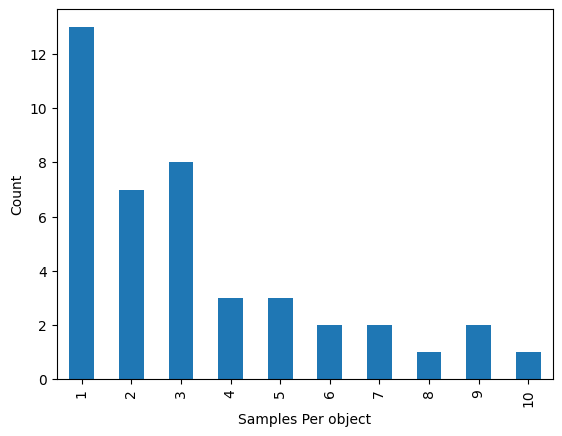

In [9]:
grouped_count_df = dataset_df.groupby('object').action.count()
# ensure each set has all actions (at least for train)
grouped_count_df.value_counts().sort_index().plot(kind='bar', xlabel='Samples Per object', ylabel='Count')

<AxesSubplot: xlabel='Samples Per Action', ylabel='Count'>

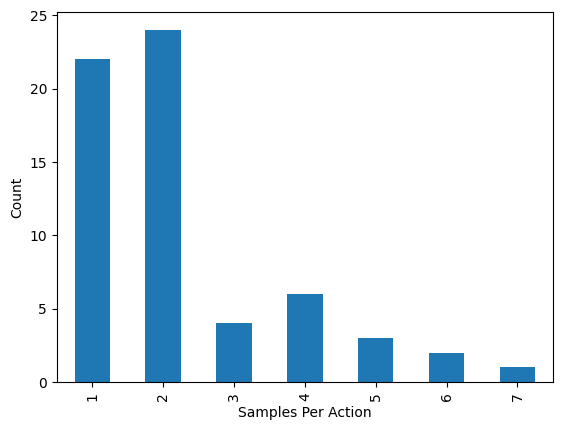

In [10]:
grouped_count_df = dataset_df.groupby('action').object.count()
# ensure each set has all actions (at least for train)
grouped_count_df.value_counts().sort_index().plot(kind='bar', xlabel='Samples Per Action', ylabel='Count')

We cannot evaluate action with only one sample (one object), just use them for training.

In [11]:
dataset_df['action_sample_count'] = dataset_df['action'].apply(lambda x: grouped_count_df[x])

In [12]:
test_df = dataset_df[dataset_df['action_sample_count'] > 1].groupby('action').sample(1, random_state=seed)
dataset_df.drop(test_df.index, inplace=True)
val_df = dataset_df[dataset_df['action_sample_count'] > 2].groupby('action').sample(1, random_state=seed)
dataset_df.drop(val_df.index, inplace=True)
train_df = dataset_df.loc[:]
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [13]:
print(f"Train: number of samples {len(train_df)} {len(train_df)/140} number of actions {train_df.action.nunique()}")
print(f"Test: number of samples {len(test_df)} {len(test_df)/140} number of actions {test_df.action.nunique()}")
print(f"Val: number of samples {len(val_df)} {len(val_df)/140} number of actions {val_df.action.nunique()}")

Train: number of samples 84 0.6 number of actions 62
Test: number of samples 40 0.2857142857142857 number of actions 40
Val: number of samples 16 0.11428571428571428 number of actions 16


In [14]:
train_df.to_pickle('./data/train.pkl')
val_df.to_pickle('./data/val.pkl')
test_df.to_pickle('./data/test.pkl')

### Prepare data for fine-tuning all-MiniLM-L6-v2

In [19]:
train_df = pd.read_pickle('./data/train.pkl')
val_df = pd.read_pickle('./data/val.pkl')
test_df = pd.read_pickle('./data/test.pkl')

In [20]:
train_df = train_df.loc[:, ['action', 'object', 'effect_sentence_list']]
val_df = val_df.loc[:, ['action', 'object', 'effect_sentence_list']]
test_df = test_df.loc[:, ['action', 'object', 'effect_sentence_list']]
train_df = pd.concat([train_df, val_df], ignore_index=True)
del val_df

In [21]:
train_df = train_df.explode('effect_sentence_list')
test_df = test_df.explode('effect_sentence_list')
train_df.rename(columns={'effect_sentence_list': 'effect_sentence'}, inplace=True)
test_df.rename(columns={'effect_sentence_list': 'effect_sentence'}, inplace=True)

In [22]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [23]:
val_df = train_df.sample(frac=0.15, random_state=seed)
train_df.drop(val_df.index, inplace=True)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [25]:
def generate_pairs(df, negative=False):
    pairs_df = pd.DataFrame(columns=['effect_sentence_1', 'effect_sentence_2', 'score']) 
    for action in tqdm(df['action'].unique()):
        for obj in df['object'].unique():
            same_effect_df = df[(df['action'] == action) & (df['object'] == obj)]
            for i in range(len(same_effect_df)):
                for j in range(i+1, len(same_effect_df)):
                    pairs_df.loc[len(pairs_df)] = [same_effect_df.iloc[i]['effect_sentence'], same_effect_df.iloc[j]['effect_sentence'], 1.0]
                    if negative:
                        neg_effect_sentence = df[(df['action'] != action) & (df['object'] != obj)].sample(1)['effect_sentence']
                        pairs_df.loc[len(pairs_df)] = [same_effect_df.iloc[i]['effect_sentence'], neg_effect_sentence.iloc[0], 0.0]
        
    pairs_df.drop_duplicates(inplace=True)
    return pairs_df
        

In [29]:
train_df_pairs = generate_pairs(train_df)
test_df_pairs = generate_pairs(test_df, negative=True)
val_df_pairs = generate_pairs(val_df, negative=True)

100%|██████████| 53/53 [00:01<00:00, 50.00it/s]


In [30]:
train_df_pairs.to_pickle('./data/train_ft_emb.pkl')
test_df_pairs.to_pickle('./data/test_ft_emb.pkl')
val_df_pairs.to_pickle('./data/val_ft_emb.pkl')

### Prepare data for effect encoding training

In [14]:
train_df = pd.read_pickle('./data/train.pkl')
val_df = pd.read_pickle('./data/val.pkl')
test_df = pd.read_pickle('./data/test.pkl')

In [5]:
train_df = train_df.loc[:, ['action', 'object', 'effect_sentence_list']]
val_df = val_df.loc[:, ['action', 'object', 'effect_sentence_list']]
test_df = test_df.loc[:, ['action', 'object', 'effect_sentence_list']]
train_df = pd.concat([train_df, val_df], ignore_index=True)
del val_df

In [6]:
train_df = train_df.explode('effect_sentence_list')
test_df = test_df.explode('effect_sentence_list')
train_df.rename(columns={'effect_sentence_list': 'effect_sentence'}, inplace=True)
test_df.rename(columns={'effect_sentence_list': 'effect_sentence'}, inplace=True)

In [7]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [8]:
train_df

,action,object,effect_sentence
0,arrange,chairs,objects are moved around in order
1,arrange,chairs,the objects are put in order
2,arrange,chairs,the objects are st in a specific order
3,arrange,chairs,objects are arranged in a specific fashion all...
4,arrange,chairs,the objects are now in a row
...,...,...,...
995,throw,apple,the object fell to the ground and shattered
996,throw,apple,the object is gliding through the air
997,throw,apple,the object is flying in the air
998,throw,apple,an object is tossed into the air


In [9]:
val_df = train_df.sample(frac=0.15, random_state=seed)
train_df.drop(val_df.index, inplace=True)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [10]:
train_df

,action,object,effect_sentence
0,arrange,chairs,objects are moved around in order
1,arrange,chairs,the objects are put in order
2,arrange,chairs,the objects are st in a specific order
3,arrange,chairs,objects are arranged in a specific fashion all...
4,arrange,chairs,the objects are now in a row
...,...,...,...
845,throw,apple,the object hurtles through the air
846,throw,apple,the object flies away into the air
847,throw,apple,the object is gliding through the air
848,throw,apple,the object is flying in the air


In [11]:
def generate_pairs(df):
    pairs_df = pd.DataFrame(columns=['same_action', 'same_object_feature', 'effect_sentence_1', 'effect_sentence_2']) 
    for action in tqdm(df['action'].unique()):
        action_df = df[df['action'] == action]
        for i in range(len(action_df)):
            for j in range(i+1, len(action_df)):
                pairs_df.loc[len(pairs_df)] = [1, action_df.iloc[i]['object'] == action_df.iloc[j]['object'], action_df.iloc[i]['effect_sentence'], action_df.iloc[j]['effect_sentence']]
    for obj in tqdm(df['object'].unique()):
        object_df = df[df['object'] == obj]
        for i in range(len(object_df)):
            for j in range(i+1, len(object_df)):
                pairs_df.loc[len(pairs_df)] = [object_df.iloc[i]['action'] == object_df.iloc[j]['action'], 1, object_df.iloc[i]['effect_sentence'], object_df.iloc[j]['effect_sentence']]
    pairs_df.drop_duplicates(inplace=True)
    return pairs_df
        

In [12]:
train_df_pairs = generate_pairs(train_df)
test_df_pairs = generate_pairs(test_df)
val_df_pairs = generate_pairs(val_df)


100%|██████████| 34/34 [00:00<00:00, 52.62it/s]


In [14]:
train_df_pairs.to_pickle('./data/train_objenc_both.pkl')
test_df_pairs.to_pickle('./data/test_objenc_both.pkl')
val_df_pairs.to_pickle('./data/val_objenc_both.pkl')

## For multiple choice

In [1]:
train_df = pd.read_pickle('./data/train_objenc_both.pkl')
test_df = pd.read_pickle('./data/test_objenc_both.pkl')
val_df = pd.read_pickle('./data/val_objenc_both.pkl')

NameError: name 'pd' is not defined

In [26]:
def to_mc_df(df):
    mc_df = pd.DataFrame(columns=['object', 'action', 'effect_sentence_1', 'effect_sentence_2', 'effect_sentence_3', 'effect_sentence_4', 'label'])
    for i in tqdm(range(len(df))):
        effect_sentences = []
        effect_sentences.append(df.iloc[i]['effect_sentence'])
        if len(train_df[(train_df['action'] == df.iloc[i]['action']) & (train_df['object'] != df.iloc[i]['object'])]):
            effect_sentences.append(train_df[(train_df['action'] == df.iloc[i]['action']) & (train_df['object'] != df.iloc[i]['object'])].sample(1, random_state=seed)['effect_sentence'].values[0])
        else:
            effect_sentences.append(train_df[(train_df['action'] != df.iloc[i]['action']) & (train_df['object'] != df.iloc[i]['object'])].sample(1, random_state=seed)['effect_sentence'].values[0])
        if len(train_df[(train_df['action'] != df.iloc[i]['action']) & (train_df['object'] == df.iloc[i]['object'])]):
            effect_sentences.append(train_df[(train_df['action'] != df.iloc[i]['action']) & (train_df['object'] == df.iloc[i]['object'])].sample(1, random_state=seed)['effect_sentence'].values[0])
        else:
            effect_sentences.append(train_df[(train_df['action'] != df.iloc[i]['action']) & (train_df['object'] != df.iloc[i]['object'])].sample(1, random_state=seed)['effect_sentence'].values[0])
        effect_sentences.append(train_df[(train_df['action'] != df.iloc[i]['action']) & (train_df['object'] != df.iloc[i]['object'])].sample(1, random_state=seed)['effect_sentence'].values[0])
        random.shuffle(effect_sentences)
        label = effect_sentences.index(df.iloc[i]['effect_sentence'])
        mc_df.loc[len(mc_df)] = [df.iloc[i]['object'], df.iloc[i]['action'], *effect_sentences, label]
    return mc_df

In [27]:
train_df_mc = to_mc_df(train_df)
val_df_mc = to_mc_df(val_df)
test_df_mc = to_mc_df(test_df)

100%|██████████| 400/400 [00:02<00:00, 183.57it/s]


In [29]:
train_df_mc.to_csv('./data/multi_choice/train.csv', index=False)
val_df_mc.to_csv('./data/multi_choice/val.csv', index=False)
test_df_mc.to_csv('./data/multi_choice/test.csv', index=False)

Try load